# Simple BiLSTM using processed data for TSLA

In [1]:
import sys
import tensorflow as tf
import pandas as pd 

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

cpu = tf.device('/CPU:0')
gpu = tf.device('/GPU:0')

Tensor Flow Version: 2.14.0
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
Pandas 1.5.3
GPU is available


2023-10-03 19:22:19.246206: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-03 19:22:19.246225: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-03 19:22:19.246230: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-03 19:22:19.246500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-03 19:22:19.246854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
from create_spark import CreateSparkSession

with cpu: 
    spark_obj = CreateSparkSession()
    spark = spark_obj.session

23/10/03 19:22:20 WARN Utils: Your hostname, Wonseoks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.35.161 instead (on interface en0)
23/10/03 19:22:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/wonseokchoi/.ivy2/cache
The jars for the packages stored in: /Users/wonseokchoi/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
io.delta#delta-core_2.12 added as a dependency
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-78686e61-7c41-4cb8-a03d-38e950afe205;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/wonseokchoi/Documents/Installs/spark-3.4.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.amazonaws#aws-java-sdk;1.11.563 in central
	found com.amazonaws#aws-java-sdk-ioteventsdata;1.11.563 in central
	found com.amazonaws#aws-java-sdk-core;1.11.563 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.2 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.11.563 in central
	found com.amazonaws#aws-java-sdk-iotevents;1.11.563 in central
	found com.amazonaws#aws-java-sdk-iotthingsgraph;1.11.563 in central
	found com.amazonaws#

In [3]:
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
with gpu:
    DF = spark.read.format('delta').load("s3a://wonseokchoi-data-lake-project/lake/gold/tsla/")

    DF = DF.withColumn("timestamp", F.from_utc_timestamp("timestamp", "UTC"))
    DF = DF.withColumn("timestamp", F.expr("timestamp - interval 5 hours"))
    DF = DF.withColumn("timestamp", F.date_format("timestamp", 'yyyy-MM-dd HH:mm:ss'))
    DF = DF.withColumnRenamed("avg_close", "close") 
    DF = DF.select("timestamp", "close").orderBy("timestamp", ascending=True)

    df = DF.toPandas()

In [5]:
train_timestamps = pd.to_datetime(df['timestamp'])
train_timestamps

0       2018-10-02 12:00:00
1       2018-10-02 13:00:00
2       2018-10-02 14:00:00
3       2018-10-02 15:00:00
4       2018-10-02 16:00:00
                ...        
20005   2023-10-02 22:00:00
20006   2023-10-02 23:00:00
20007   2023-10-03 00:00:00
20008   2023-10-03 01:00:00
20009   2023-10-03 02:00:00
Name: timestamp, Length: 20010, dtype: datetime64[ns]

In [6]:
cols = list(df)[1:2]
cols

['close']

In [7]:
df_for_training = df[cols].astype(float)
df_for_training

,close
0,20.614018
1,20.590908
2,20.602338
3,20.544776
4,20.696649
...,...
20005,248.816101
20006,250.124186
20007,251.523195
20008,251.232564


<Axes: >

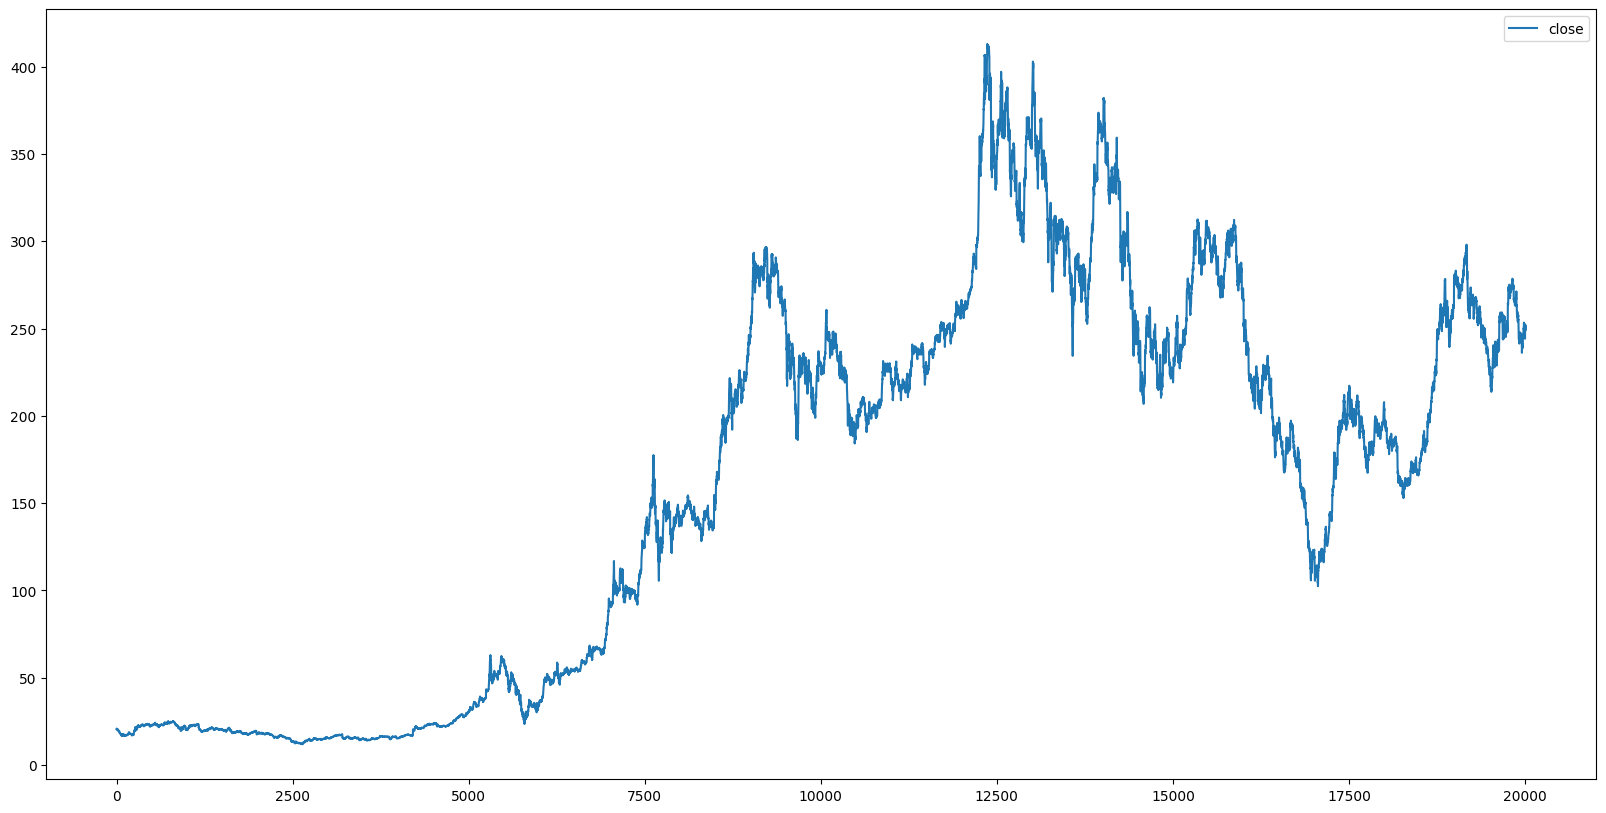

In [8]:
df_for_plot = df_for_training
df_for_plot.plot.line(figsize=(20, 10))

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()

scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[-1.25487711],
       [-1.25508411],
       [-1.25498173],
       ...,
       [ 0.81338384],
       [ 0.81078065],
       [ 0.80900251]])

In [11]:
trainX = []
trainY = []

n_future = 1
n_past = 6*5*4

with gpu: 
    for i in range (n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print("trainX shape == {}.".format(trainX.shape))
    print("trainY shape == {}.".format(trainY.shape))

trainX shape == (19890, 120, 1).
trainY shape == (19890, 1).


In [12]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

In [13]:
with gpu:
    model = Sequential()
    activation_fn = 'tanh'

    model.add(Bidirectional(LSTM(128, activation=activation_fn, return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(128, activation=activation_fn, return_sequences=True)))
    model.add(Dropout(0.2))
    
    model.add(Bidirectional(LSTM(128, activation=activation_fn)))
    model.add(Dropout(0.2))

    model.add(Dense(trainY.shape[1]))

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 120, 256)          133120    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 120, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 120, 256)          394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 120, 256)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                        

In [17]:
with gpu:
    history = model.fit(trainX, trainY, epochs=100, batch_size=256, validation_split=0.1, verbose=1)

Epoch 1/100
70/70 [==============================] - 18s 233ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 2/100
70/70 [==============================] - 15s 209ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 3/100
70/70 [==============================] - 15s 208ms/step - loss: 0.0020 - val_loss: 9.0445e-04
Epoch 4/100
70/70 [==============================] - 14s 207ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 5/100
70/70 [==============================] - 14s 206ms/step - loss: 0.0016 - val_loss: 7.9681e-04
Epoch 6/100
70/70 [==============================] - 14s 205ms/step - loss: 0.0013 - val_loss: 7.9604e-04
Epoch 7/100
70/70 [==============================] - 15s 211ms/step - loss: 0.0014 - val_loss: 8.0699e-04
Epoch 8/100
70/70 [==============================] - 18s 253ms/step - loss: 0.0010 - val_loss: 7.3863e-04
Epoch 9/100
70/70 [==============================] - 23s 323ms/step - loss: 0.0010 - val_loss: 5.6049e-04
Epoch 10/100
70/70 [==============================] - 25s 

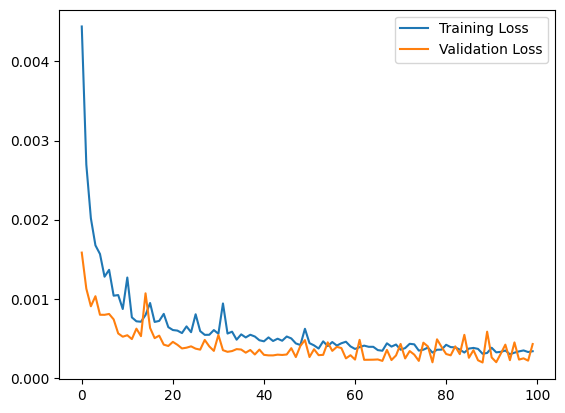

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [19]:
n_past = 1
n_for_prediction = 24*5
predict_period_dates = pd.date_range(list(train_timestamps)[-n_past], periods=n_for_prediction, freq='H').tolist()

In [20]:
prediction = model.predict(trainX[-n_for_prediction:])

4/4 [==============================] - 4s 114ms/step


In [21]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)

prediction_copies.shape

(120, 1)

In [22]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

In [23]:
# Function to replicate each business day to hourly intervals
def replicate_to_hourly(business_days, trading_hours_start, trading_hours_end):
    hourly_timestamps = []
    for business_day in business_days:
        for hour in range(trading_hours_start, trading_hours_end):
            new_time = pd.Timestamp(f"{business_day.date()} {hour:02d}:00:00")
            hourly_timestamps.append(new_time)
    return pd.Series(hourly_timestamps)

# Define trading hours
trading_hours_start = 9  # 9:30 a.m. rounded down
trading_hours_end = 16  # 4:00 p.m.

hourly_timestamps = replicate_to_hourly(predict_period_dates, trading_hours_start, trading_hours_end)

df_forecast = pd.DataFrame({
    'timestamp': hourly_timestamps,
    'close': np.repeat(y_pred_future, trading_hours_end - trading_hours_start)
})

df_forecast['timestamp'] = pd.to_datetime(df_forecast['timestamp'])

<Axes: xlabel='timestamp', ylabel='close'>

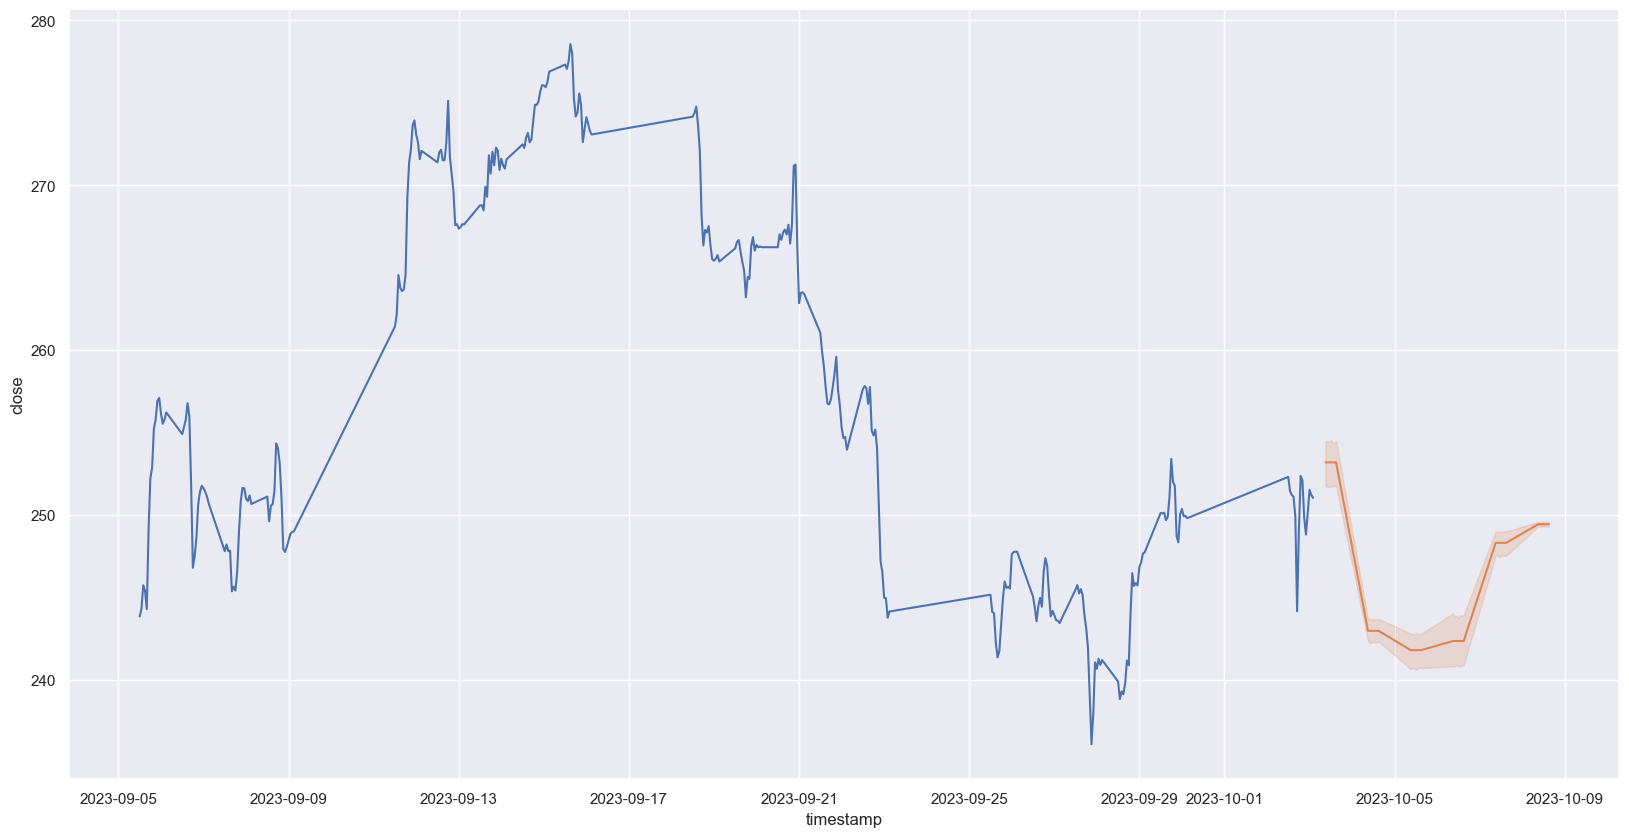

In [24]:
from datetime import datetime, timedelta

month = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')

original = df[['timestamp', 'close']].copy()
original['timestamp'] = pd.to_datetime(original['timestamp'])

original = original.loc[original['timestamp'] >= month]

sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(x='timestamp', y='close', data=original)
sns.lineplot(x='timestamp', y='close', data=df_forecast)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Calculate metrics
y_true = df_for_training[-n_for_prediction:]
mae = mean_absolute_error(y_true, y_pred_future)
mse = mean_squared_error(y_true, y_pred_future)
rmse = sqrt(mse)
r2 = r2_score(y_true, y_pred_future)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 2.074718439077119
Mean Squared Error: 5.80853182018346
Root Mean Squared Error: 2.4100895875845487
R-squared: 0.7822169937241297


In [27]:
model.save("../models/tsla_bilstm.h5")
model.save_weights("../models/tsla_bilstm_weights.h5")

/Users/wonseokchoi/miniforge3/envs/alpha/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [173]:
from pyspark.sql.functions import col, to_utc_timestamp, to_timestamp

test['timestamp_str'] = test['timestamp'].astype(str)

DF_forecast = spark.createDataFrame(df_forecast)
DF_forecast = DF_forecast.withColumn("timestamp", to_utc_timestamp(col("timestamp_str"), "UTC"))
DF_forecast = DF_forecast.drop('timestamp')
DF_forecast = DF_forecast.withColumnRenamed("timestamp_str", "timestamp")
DF_forecast = DF_forecast.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))

In [176]:
save_path = "s3a://wonseokchoi-data-lake-project/lake/ml/tsla/"

with cpu: 
    DF_forecast.write \
        .format("delta") \
        .mode("overwrite") \
        .save(save_path)

    DF_forecast.write\
        .format("org.apache.spark.sql.cassandra")\
        .options(table="tsla", keyspace="ml")\
        .option("confirm.truncate", "true")\
        .mode("overwrite")\
        .save()

In [177]:
spark.stop()